In [4]:
import cv2
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from IPython.display import display
from skimage.draw import line
from math import dist

In [11]:
class EuristicGraspGenerator:
    def __init__(self, data_path):
        self.dataset_dir = data_path
        self.background_path = os.path.join(self.dataset_dir, "background.png")
        self.rgbs = glob.glob(os.path.join(self.dataset_dir, "pcd????r.png"))
        self.depths = glob.glob(os.path.join(
            self.dataset_dir, "pcd????d.tiff"))
        self.poss = glob.glob(os.path.join(
            self.dataset_dir, "pcd????cpos.txt"))
        self.bboxes = glob.glob(os.path.join(
            self.dataset_dir, "pcd????bbox.txt"))
        self.contours = glob.glob(os.path.join(
            self.dataset_dir, "pcd????cont.txt"))
        self.meanlines = glob.glob(os.path.join(
            self.dataset_dir, "pcd????meanline.txt"))
        self.minboxes = glob.glob(os.path.join(
            self.dataset_dir, "pcd????minbox.txt"))
        self.rgbs.sort()
        self.depths.sort()
        self.poss.sort()
        self.bboxes.sort()
        self.contours.sort()
        self.meanlines.sort()
        self.minboxes.sort()

        self.colors = [list(np.random.random(size=3) * 256) for _ in range(20)]

    def read_i(self, i):
        self.rgb = cv2.imread(self.rgbs[i])
        # self.rgb = cv2.cvtColor(self.rgb, cv2.COLOR_BGR2RGB)
        print("RGB: ", os.path.split(self.rgbs[i])[-1])

        self.depth = Image.open(self.depths[i])
        # im.show()
        self.depth = np.array(self.depth)

        self.rows, self.cols = self.rgb.shape[:2]

        self.pos_points = np.genfromtxt(self.poss[i], dtype="float")
        self.pos_points = self.pos_points.reshape(-1, 4, 2).astype(int)

        self.bbox = np.genfromtxt(self.bboxes[i], dtype="int")
        self.contour = np.genfromtxt(self.contours[i], dtype="int")
        [self.meanline_vx, self.meanline_vy, self.meanline_x,
            self.meanline_y] = np.genfromtxt(self.meanlines[i], dtype="float")
        self.minbox = np.genfromtxt(self.minboxes[i], dtype="int")

        self.rgb_copy = self.rgb.copy()
        self.cropped_rgb = self.crop_bbox(self.rgb_copy, self.bbox)
        self.depth_copy = self.depth.copy()
        self.normalized_depth = self.normalize(self.depth_copy)
        self.cropped_normalized_depth = self.normalize(
            self.crop_bbox(self.depth_copy, self.bbox))

        self.meanline_lefty, self.meanline_righty = self.find_line_coords(
            self.meanline_vx, self.meanline_vy, self.meanline_x, self.meanline_y)
        self.meanline_intersection_points = self.find_intersection(
            self.cols-1, self.meanline_righty, 0, self.meanline_lefty, self.contour)
        self.meanline_perp_vx, self.meanline_perp_vy = self.perpendicular(
            (self.meanline_vx, self.meanline_vy))

    def crop_bbox(self, img, bbox, margin=50):
        [left, top] = bbox[0] - margin
        [right, bottom] = bbox[1] + margin
        return img[top:bottom, left:right]

    def normalize(self, depth):
        depth = depth.copy()
        return (depth - np.min(depth)) / (np.max(depth) - np.min(depth))

    def find_line_coords(self, vx, vy, x, y):
        lefty = int((-x*vy/vx) + y)
        righty = int(((self.cols-x)*vy/vx)+y)
        return lefty, righty

    def perpendicular(self, a):
        a = np.array(a)
        a = a/np.linalg.norm(a)
        b = np.empty_like(a)
        b[0] = -a[1]
        b[1] = a[0]
        return b

    def draw_all(self):
        for i, rect in enumerate(self.pos_points):
            cv2.drawContours(
                self.rgb_copy, [rect], 0, color=self.colors[i], thickness=4)

        cv2.rectangle(
            self.rgb_copy, (self.bbox[0]), (self.bbox[1]), (0, 255, 0), 2)

        cv2.drawContours(self.rgb_copy, [self.contour], -1, (255, 0, 255), 2)
        cv2.drawContours(
            self.rgb_copy, [self.minbox], 0, (255, 0, 0), 2, cv2.FILLED)

        cv2.line(self.rgb_copy, (self.cols-1, self.meanline_righty),
                 (0, self.meanline_lefty), (255, 255, 0), 2)

        for grab in self.grab_widths_points:
            # cv2.line(self.rgb_copy, grab[0], grab[1], (0, 255, 255), 2)
            cv2.circle(self.rgb_copy, grab[0], 2, (0, 0, 255), 2)
            cv2.circle(self.rgb_copy, grab[1], 2, (0, 0, 255), 2)
        
        for point in self.meanline_intersection_points:
            cv2.circle(self.rgb_copy, point, 2, (0, 0, 255), 2)

        for point in self.grab_center_points:
            cv2.circle(self.rgb_copy, point, 2, (0, 0, 255), 2)

    def show_i(self, i):
        self.generate_grasps_for_bottle(i)
        self.draw_all()
        print("Depth max min: ", self.depth_copy.max(), self.depth_copy.min())
        print("Depth normalized max min: ",
              self.normalized_depth.max(), self.normalized_depth.min())
        print("Depth cropped normalized max min: ",
              self.cropped_normalized_depth.max(), self.cropped_normalized_depth.min())

        fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

        axes[0, 0].imshow(self.rgb)
        axes[0, 1].imshow(self.rgb_copy)
        axes[1, 0].imshow(self.depth)
        axes[1, 1].imshow(self.normalized_depth)
        axes[2, 0].imshow(self.cropped_rgb)
        plot = axes[2, 1].imshow(self.cropped_normalized_depth)
        plt.colorbar(plot)

    def find_intersection(self, x1, y1, x2, y2, contour):
        points = []
        for (pt1, pt2) in zip(*line(x1, y1, x2, y2)):
            point = (int(pt1), int(pt2))
            # If the point is on the contour
            if cv2.pointPolygonTest(contour, point, False) == 0:
                points.append(point)
        return points

    def generate_grasps_for_bottle(self, i, px_delta=20):
        self.read_i(i)

        divider = int(dist(
            self.meanline_intersection_points[0], self.meanline_intersection_points[1]) / px_delta)
        if divider == 0:
            return

        print("divider", divider)
        print("distance(points[0], points[1])", dist(
            self.meanline_intersection_points[0], self.meanline_intersection_points[1]))
        delta_x = (
            self.meanline_intersection_points[1][0] - self.meanline_intersection_points[0][0]) / divider
        delta_y = (
            self.meanline_intersection_points[1][1] - self.meanline_intersection_points[0][1]) / divider

        self.grab_center_points = []
        self.grab_widths_points = []

        for idiv in range(1, int(divider)):
            center_point = (int(self.meanline_intersection_points[0][0] + delta_x*idiv), int(
                self.meanline_intersection_points[0][1] + delta_y*idiv))
            self.grab_center_points.append(center_point)
            lefty, righty = self.find_line_coords(
                self.meanline_perp_vx, self.meanline_perp_vy, center_point[0], center_point[1])
            widths_points = self.find_intersection(
                self.cols-1, righty, 0, lefty, self.contour)
            if len(widths_points) < 2:
                continue
            self.grab_widths_points.append(widths_points)

        # rgb_copy = rgb.copy()

    def test_bottle_generation(self, step=20):
        for i in range(0, len(self.rgbs), step):
            if i > len(self.rgbs):
                break

            self.generate_grasps_for_bottle(i)

            self.draw_all()

            name = "out/img%d.jpg" % i
            print(name)
            cv2.imwrite(name, self.cropped_rgb)


In [12]:
bottle_generator = EuristicGraspGenerator(data_path="/home/vladushked/Documents/data/leolab_grasping_dataset/plastic/bottles")

RGB:  pcd0001r.png
divider 6
distance(points[0], points[1]) 124.40257232067188
Depth max min:  31.039001 0.0
Depth normalized max min:  1.0 0.0
Depth cropped normalized max min:  1.0 0.0


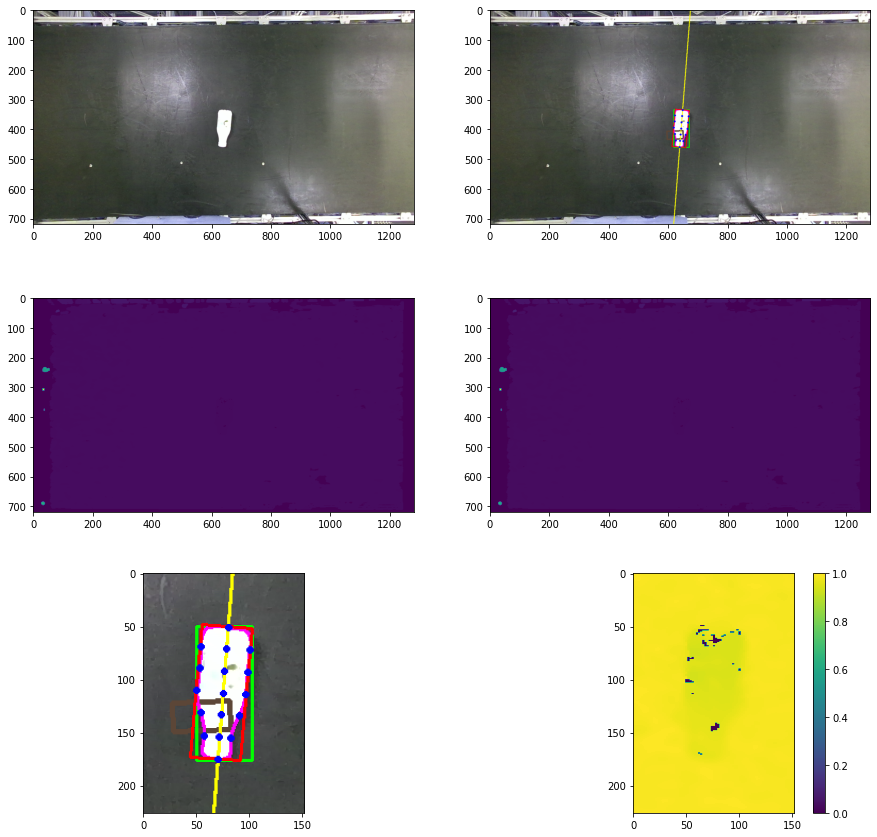

In [13]:
bottle_generator.show_i(0)

In [15]:
bottle_generator.test_bottle_generation()

RGB:  pcd0001r.png
divider 6
distance(points[0], points[1]) 124.40257232067188
out/img0.jpg
RGB:  pcd0021r.png
divider 8
distance(points[0], points[1]) 173.80736463107655
out/img20.jpg
RGB:  pcd0041r.png
divider 7
distance(points[0], points[1]) 159.8311609167624
out/img40.jpg
RGB:  pcd0061r.png
divider 6
distance(points[0], points[1]) 139.58868148958211
out/img60.jpg
RGB:  pcd0081r.png
divider 7
distance(points[0], points[1]) 142.01408380861386
out/img80.jpg
RGB:  pcd0101r.png
divider 7
distance(points[0], points[1]) 145.7737973711325
out/img100.jpg
RGB:  pcd0121r.png
divider 9
distance(points[0], points[1]) 185.88437266214714
out/img120.jpg
RGB:  pcd0141r.png
out/img140.jpg
RGB:  pcd0161r.png
divider 2
distance(points[0], points[1]) 46.270941205037104
out/img160.jpg
RGB:  pcd0181r.png


/tmp/ipykernel_4694/2665564173.py:39: UserWarning: genfromtxt: Empty input file: "/home/vladushked/Documents/data/leolab_grasping_dataset/plastic/bottles/pcd0141cpos.txt"
  self.pos_points = np.genfromtxt(self.poss[i], dtype="float")
/tmp/ipykernel_4694/2665564173.py:39: UserWarning: genfromtxt: Empty input file: "/home/vladushked/Documents/data/leolab_grasping_dataset/plastic/bottles/pcd0161cpos.txt"
  self.pos_points = np.genfromtxt(self.poss[i], dtype="float")
/tmp/ipykernel_4694/2665564173.py:39: UserWarning: genfromtxt: Empty input file: "/home/vladushked/Documents/data/leolab_grasping_dataset/plastic/bottles/pcd0181cpos.txt"
  self.pos_points = np.genfromtxt(self.poss[i], dtype="float")


divider 7
distance(points[0], points[1]) 157.26728839781018
out/img180.jpg
RGB:  pcd0201r.png
divider 6
distance(points[0], points[1]) 138.1774221788784
out/img200.jpg
RGB:  pcd0221r.png
divider 8
distance(points[0], points[1]) 161.02794788483146
out/img220.jpg
RGB:  pcd0241r.png
divider 7
distance(points[0], points[1]) 159.31415505221122
out/img240.jpg
RGB:  pcd0261r.png
divider 9
distance(points[0], points[1]) 181.0
out/img260.jpg
RGB:  pcd0281r.png
divider 6
distance(points[0], points[1]) 139.2300254973761
out/img280.jpg
